This notebook proposes a simple demonstration of the impacts of data augmentation on a deep learning model's performance.

For that matter, Keras "ImageDataGenerator" class is used for its practical and robust approach.

The problem to be solved is a **binary classification** between images containing or not pizza.

In [2]:
# dataset pizza or not pizza
# https://www.kaggle.com/datasets/carlosrunner/pizza-not-pizza

# please note:
# kaggle.json (kaggle API token) file is required to access the dataset
# through the method used in this notebook.

In [3]:
import warnings 
warnings.filterwarnings("always") 
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from tensorflow.keras.optimizers import Nadam, Adam
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout, Flatten, Input, Dense
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import random
import tensorflow as tf
import cv2
import os 
import glob

from google.colab import output

%matplotlib inline  
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [4]:
# requires kaggle.json

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# dataset download
! kaggle datasets download carlosrunner/pizza-not-pizza
! unzip pizza-not-pizza.zip

# remove .zip and .py files
! rm pizza-not-pizza.zip
! rm pizza_not_pizza/food101_subset.py

# clear cell output
output.clear()

In [5]:
dataset_path = "pizza_not_pizza"

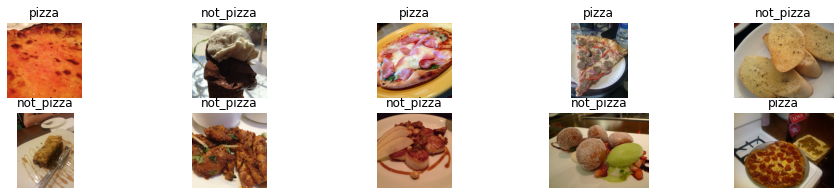

Class order:  ['pizza', 'not_pizza']


In [7]:
# Some dataset image examples:
classes=os.listdir(dataset_path)

plt.figure(figsize=(16,8))

for x in range(10):
  i=random.randint(0,1)
  images=os.listdir(dataset_path+"/"+classes[i])
  j=random.randint(0,900)
  image=cv2.imread(dataset_path+"/"+classes[i]+"/"+images[j])
  image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
  ax=plt.subplot(5,5,x+1)
  plt.imshow(image)
  plt.title(classes[i])
  plt.axis("off")
    
    
plt.show()

print("Class order: ", classes)

In [9]:
# Creating class array

pizza_dir = glob.glob(os.path.join(dataset_path, r"pizza" , "*.jpg"))
not_pizza_dir = glob.glob(os.path.join(dataset_path, r"not_pizza" , "*.jpg"))

X_path = pizza_dir + not_pizza_dir
X = []
for f in X_path:
  X.append(np.array(cv2.resize(cv2.imread(f), (256,256), interpolation = cv2.INTER_AREA))) 
X = np.array(X)
X = X / 255

# Shape must be 983 pizza + 983 not_pizza = 1966, 256, 256, 3
print(X.shape)

(1966, 256, 256, 3)


In [10]:
# Creating label array

label_pizza = np.zeros(shape=len(pizza_dir))
label_pizza_srting = ["pizza" for img in pizza_dir]

label_not_pizza = np.ones(shape=len(pizza_dir))
label_not_pizza_string = ["not_pizza" for img in not_pizza_dir]

y_string = np.concatenate((label_pizza_srting,label_not_pizza_string))
y = np.concatenate((label_pizza, label_not_pizza))
y = to_categorical(y, 2)

# Shape must be 983 pizza + 983 not_pizza = 1966, 2
print(y.shape)

(1966, 2)


In [11]:
# Spçitting train and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
X = []
print("X_train.shape: ", X_train.shape)
print("X_val.shape: ", X_val.shape)
print("y_train.shape: ", y_train.shape)
print("y_val.shape: ", y_val.shape)

X_train.shape:  (1572, 256, 256, 3)
X_val.shape:  (394, 256, 256, 3)
y_train.shape:  (1572, 2)
y_val.shape:  (394, 2)


In [12]:
# Neural Network

inp = Input((256,256,3))
conv1 = Conv2D(64, (5,5), padding="valid", activation= "relu")(inp)
conv1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv1 = BatchNormalization()(conv1)
conv2 = Conv2D(96, (4,4), padding="valid", activation= "relu")(conv1)
conv2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv2 = BatchNormalization()(conv2)
conv3 = Conv2D(128, (3,3), padding="valid", activation= "relu")(conv2)
conv3 = MaxPooling2D(pool_size=(2,2))(conv3)
conv3 = BatchNormalization()(conv3)
conv4 = Conv2D(256, (3,3), padding="valid", activation= "relu")(conv3)
conv4 = MaxPooling2D(pool_size=(2,2))(conv4)
conv4 = BatchNormalization()(conv4)
flat = Flatten()(conv4)
dense1 = Dense(512, activation= "relu")(flat)
dense1 = Dropout(0.5)(dense1)
dense2 = Dense(64, activation= "relu")(dense1)
dense2 = Dropout(0.1)(dense2)
out = Dense(2, activation = "softmax")(dense2)
model = Model(inp, out)
model.compile(optimizer = Nadam(lr = 0.0001) , loss = "binary_crossentropy", metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 252, 252, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 96)      98400     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 96)       0     

In [14]:
# Train without data augmentation
history = model.fit(X_train, y_train, batch_size = 32, epochs = 40, initial_epoch = 0, validation_data = (X_val, y_val))

Epoch 1/40
50/50 [==============================] - 33s 375ms/step - loss: 0.8280 - categorical_accuracy: 0.6781 - val_loss: 0.8613 - val_categorical_accuracy: 0.5076
Epoch 2/40
50/50 [==============================] - 17s 343ms/step - loss: 0.4724 - categorical_accuracy: 0.8467 - val_loss: 0.7973 - val_categorical_accuracy: 0.5076
Epoch 3/40
50/50 [==============================] - 17s 347ms/step - loss: 0.3165 - categorical_accuracy: 0.8957 - val_loss: 0.7087 - val_categorical_accuracy: 0.5609
Epoch 4/40
50/50 [==============================] - 17s 350ms/step - loss: 0.1996 - categorical_accuracy: 0.9472 - val_loss: 1.2299 - val_categorical_accuracy: 0.5076
Epoch 5/40
50/50 [==============================] - 18s 353ms/step - loss: 0.1455 - categorical_accuracy: 0.9606 - val_loss: 1.0142 - val_categorical_accuracy: 0.5178
Epoch 6/40
50/50 [==============================] - 17s 350ms/step - loss: 0.0916 - categorical_accuracy: 0.9784 - val_loss: 2.0619 - val_categorical_accuracy: 0.507

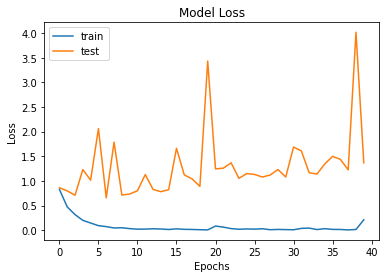

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

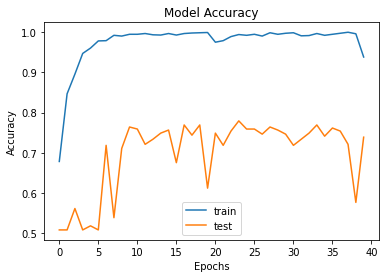

In [16]:
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

**results *without* data augmentation:**
- There is some serious overfitting problem. Accuracy of 0,99 is achieved right in the 8th epoch while validation accuracy orbits around 0,53 and 0,71.
- The model "struggles" to score vallidation accuracy above 0.8 
- Validation loss remains above 1 in the last epochs. Also, it seems that this value is either stable or growing over the epochs.


Found 1966 images belonging to 2 classes.


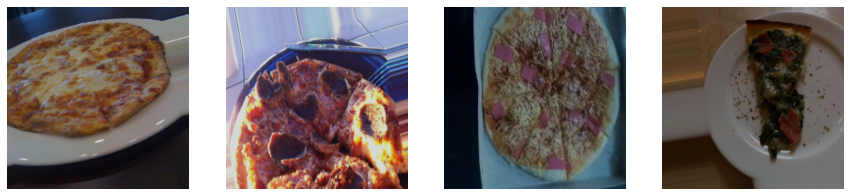

In [18]:
# Some possible augmentations

datagen = ImageDataGenerator(
        rotation_range=30,            # rotation range (maximum degrees)
        width_shift_range=0.2,        # horizontal shift range
        height_shift_range=0.2,       # vertical shift
        zoom_range=0.2,               # zoom
        horizontal_flip=True,         # horizontal flip
        brightness_range=[0.6,1.4])   # brightness

train_generator = datagen.flow_from_directory(
    directory= r"pizza_not_pizza",
    target_size=(256,256),
    color_mode="rgb",
    batch_size=1,
    class_mode="binary",
    seed=144
)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
  image = next(train_generator)[0].astype("uint8")
  image = np.squeeze(image, axis=0)  

  ax[i].imshow(image)
  ax[i].axis("off")

In [19]:
# Using data augmentation while training the network

batch_size = 32
epochs = 40

# augmentation parameters
datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
)

# train the network with data augmentation on the run
history = model.fit(datagen.flow(X_train,
                                 y_train,
                                 batch_size = batch_size,
                                 seed = 42,
                                 shuffle = True),
                    epochs = epochs,
                    steps_per_epoch = (len(X_train) / batch_size),
                    initial_epoch = 0,
                    validation_data = (X_val, y_val))

Epoch 1/40
49/49 [==============================] - 27s 555ms/step - loss: 1.0618 - categorical_accuracy: 0.7392 - val_loss: 0.8046 - val_categorical_accuracy: 0.7360
Epoch 2/40
49/49 [==============================] - 28s 564ms/step - loss: 0.7879 - categorical_accuracy: 0.7455 - val_loss: 0.9068 - val_categorical_accuracy: 0.6726
Epoch 3/40
49/49 [==============================] - 27s 542ms/step - loss: 0.6048 - categorical_accuracy: 0.7824 - val_loss: 0.7432 - val_categorical_accuracy: 0.7665
Epoch 4/40
49/49 [==============================] - 27s 539ms/step - loss: 0.5493 - categorical_accuracy: 0.7907 - val_loss: 0.5257 - val_categorical_accuracy: 0.7716
Epoch 5/40
49/49 [==============================] - 27s 540ms/step - loss: 0.5409 - categorical_accuracy: 0.7805 - val_loss: 0.4989 - val_categorical_accuracy: 0.8046
Epoch 6/40
49/49 [==============================] - 27s 541ms/step - loss: 0.4609 - categorical_accuracy: 0.8136 - val_loss: 0.4316 - val_categorical_accuracy: 0.802

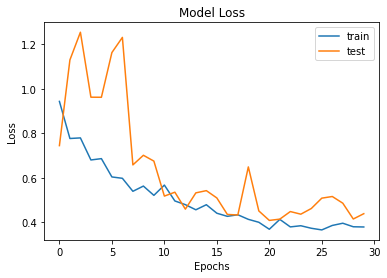

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

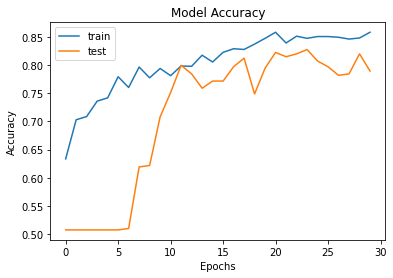

In [ ]:
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

**results *with* data augmentation:**
- Its seems that our classic overfitting problem is solved. Both train accuracy and validation accuracy scores are closer to each other. This fact indicate better generalization (we can't be sure withuot a test set) 
- Overall this model achieved better scores. Validation accuracy is about 0,82 in epoch 40. Also it appears that there is still room for improvements over the epochs.
- Validation loss is lower and keeps decreasing over the epochs.